# Hackathon

Some utilities

## Import Utils

In [ ]:
!pip install keras
!pip install tables

In [24]:
import keras
from keras.metrics import top_k_categorical_accuracy
import h5py as h5
import numpy as np
import pandas as pd
import tables

PATH_DATA = '/notebooks/data/full.h5'
PATH_PREDICT_WITHOUT_GT = '/notebooks/data/pred_students/pred_from_half/pred_eighties_from_half_1_without_gt.h5'
PATH_SUBMIT = '/notebooks/ChallengeHacka/pred_eighties_from_half_1_gr6.csv'
# PATH_PREDICT_WITH_GT = '/pred_teachers/pred_eighties_from_half_1.h5'

In [2]:
BATCH_SIZE = 32
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout
import keras.layers.normalization 
from keras.callbacks import Callback
%load_ext autoreload
%autoreload 2

In [25]:
def get_idxs(h5_path):
    f = h5.File(h5_path)
    return range(len(f['S2']))

def shuffle_idx(sample_idxs):
    return list(np.random.permutation(sample_idxs))

def split_train_val(sample_idxs, proportion):
    n_samples = len(sample_idxs)
    return sample_idxs[:int((1.-proportion)*n_samples)], sample_idxs[int((1.-proportion)*n_samples):]

def get_batch_count(idxs, batch_size):
    batch_count = int(len(idxs)//batch_size)
    remained_samples = len(idxs)%batch_size
    if remained_samples > 0:
        batch_count += 1

    return batch_count

In [26]:
def generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    while True : 
        idxs = shuffle_idx(idxs)
        batch_count = get_batch_count(idxs, batch_size)
        for b in range(batch_count):
            batch_idx = idxs[b*batch_size]
            X = f['S2'][batch_idx:batch_idx+batch_size, :,:,:]
            Y = f['TOP_LANDCOVER'][batch_idx:batch_idx+batch_size, :]
            for i in range(len(Y)) :
                if Y[i] < 6 :
                    Y[i] -= 1
                elif 9 < Y[i] < 13:
                    Y[i] = Y[i]-5
                elif Y[i] == 14:
                    Y[i] = 8
                elif Y[i] == 17:
                    Y[i] = 9
                elif Y[i] == 19:
                    Y[i] = 10
                elif Y[i] == 20:
                    Y[i] = 11
                else : 
                    Y[i] = 0
                            
            yield np.array(X), keras.utils.np_utils.to_categorical(np.array(Y), 12)

In [27]:
idxs = get_idxs(PATH_DATA)
shuffled_idxs = shuffle_idx(idxs)
train_idxs, val_idxs = split_train_val(shuffled_idxs, 0.2)

print(len(idxs))

18698240


In [28]:
train_gen = generator(PATH_DATA, BATCH_SIZE, train_idxs)
train_batch_count = get_batch_count(train_idxs, BATCH_SIZE)

val_gen = generator(PATH_DATA, BATCH_SIZE, val_idxs)
val_batch_count = get_batch_count(val_idxs, BATCH_SIZE)

In [29]:
print(train_batch_count, val_batch_count)

467456 116864


In [30]:
label = h5.File(PATH_DATA)['TOP_LANDCOVER']
images = h5.File(PATH_DATA)['S2']

unique, counts = np.unique(top_landcover, return_counts=True)

print(np.concatenate((unique, counts))

SyntaxError: unexpected EOF while parsing (<ipython-input-30-b88e90f76097>, line 6)

In [10]:
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

# Instanciation du model

In [11]:
input_shape = (16,16,4)

dropout_rate=0.5

model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='softmax'))

# Fit

In [31]:
# optim = keras.optimizers.Adam(lr=0.001)
optim = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.compile(optimizer=optim,
              loss='categorical_crossentropy',
              metrics=['accuracy', top_3_accuracy, top_5_accuracy ])

history = model.fit_generator(train_gen, steps_per_epoch=train_batch_count/20, epochs=1, verbose=1, validation_data=val_gen, nb_val_samples=1000)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=1, validation_steps=1000, verbose=1, steps_per_epoch=23372.8, validation_data=<generator...)`
  


Epoch 1/1
  278/23372 [..............................] - ETA: 5:30:27 - loss: 2.1213 - acc: 0.3054 - top_3_accuracy: 0.6168 - top_5_accuracy: 0.83

KeyboardInterrupt: 

## Prediction routines

In order to submit a result here are some gits

In [18]:
def prediction_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        X = f['S2'][batch_idxs, :,:,:]
        yield np.array(X)

In [19]:
pred_idx = get_idxs(PATH_PREDICT_WITHOUT_GT)
pred_gen = prediction_generator(PATH_PREDICT_WITHOUT_GT, BATCH_SIZE, pred_idx)
prediction = model.predict_generator(pred_gen, steps=get_batch_count(pred_idx, BATCH_SIZE), verbose=1)

preds = np.argmax(prediction, axis = 1)

for a in range(12) :
    indexes= np.where(preds == a)
    if a < 5 :
        preds[indexes] = a + 1
    elif 4 < a < 8:
        preds[indexes] =  (a-5)
    elif a == 8:
        preds[indexes] = 14
    elif a == 9:
        preds[indexes] = 17
    elif a == 10:
        preds[indexes] = 19
    elif a == 11:
        preds[indexes] = 20
    
panda_prediction = pd.DataFrame(preds)
panda_prediction.columns = ['TOP_LANDCOVER']

7554/7554 [==============================] - 460s 61ms/step


[ 0  1  2 14 17 19 20]
[  2654   9590      7   3983  18870 195163  11433]


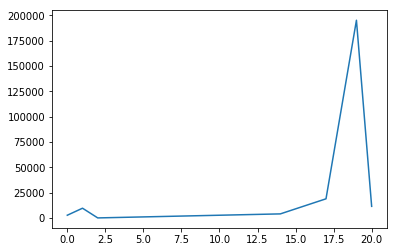

In [23]:
import matplotlib.pyplot as plt

unique, counts = np.unique(preds, return_counts=True)
print(unique)
print(counts)

plt.plot(unique, counts)
plt.show()

In [ ]:
panda_prediction.to_csv(PATH_SUBMIT, index_label = 'ID')